<a href="https://colab.research.google.com/github/Nikita018/Image-Segmentation/blob/master/src/U_net_on_camvid_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mouting google drive
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [3]:
!pip install -q git+https://github.com/tensorflow/examples.git

In [0]:
!pip install -q pyyaml h5py

In [0]:
# importing the libraries and packages
import tensorflow as tf
import numpy as np
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow import keras


import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt
import os
import cv2

In [0]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [0]:
# Define the sequential model
def create_model(base_model,OUTPUT_CHANNELS):
  # building these layers on top the pretrained model

  layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
  ]
  layers = [base_model.get_layer(name).output for name in layer_names]
  down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
  down_stack.trainable = False
  up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
  ]
  model = unet_model(OUTPUT_CHANNELS)

  model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  return model

In [46]:
# Model specific details

OUTPUT_CHANNELS = 3
# pretrained MobileNetV2 model from keras applications
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Create a basic model instance
model = create_model(base_model,OUTPUT_CHANNELS)

# Display the model's architecture
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, 64, 64, 96), 1841984     input_12[0][0]                   
__________________________________________________________________________________________________
sequential (Sequential)         (None, 8, 8, 512)    1476608     model[8][4]                      
__________________________________________________________________________________________________
concatenate_28 (Concatenate)    (None, 8, 8, 1088)   0           sequential[7][0]                 
                                                                 model[8][3]               

In [0]:
# function name : create_mask
# Input         : prediction from model
# Output        : returns true prediction taking the max value for all channels
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

# Plots an image
def plot(img):
  plt.imshow(img)
  plt.show()

# function name : define_channels
# Input         : image
# Output        : converts image to include 3 classes - Road, Pedestrian, Others
def define_channels(label):
  label_mask=np.zeros((label.shape[0],label.shape[1]))
  for i in range(label.shape[0]):
    for j in range(label.shape[1]):
      if label[i][j][0]==64 and label[i][j][1]==64 and label[i][j][2]==0:
        label_mask[i,j] = 1 
      elif label[i][j][0]==128 and label[i][j][1]==64 and label[i][j][2]==128:
        label_mask[i,j] = 2
  return label_mask

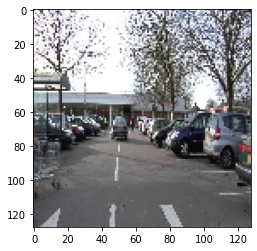

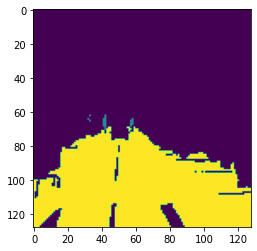

(1, 128, 128, 3)
(1, 128, 128)
Epoch 1/100
1/1 [==============================] - 0s 1ms/step - loss: 1.3301 - accuracy: 0.3578
Epoch 2/100
1/1 [==============================] - 0s 1ms/step - loss: 1.0391 - accuracy: 0.4635
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.8828 - accuracy: 0.5560
Epoch 4/100
1/1 [==============================] - 0s 1ms/step - loss: 0.8058 - accuracy: 0.6118
Epoch 5/100
1/1 [==============================] - 0s 1ms/step - loss: 0.7636 - accuracy: 0.6369
Epoch 6/100
1/1 [==============================] - 0s 1ms/step - loss: 0.7309 - accuracy: 0.6556
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.6999 - accuracy: 0.6674
Epoch 8/100
1/1 [==============================] - 0s 1ms/step - loss: 0.6713 - accuracy: 0.6736
Epoch 9/100
1/1 [==============================] - 0s 1ms/step - loss: 0.6451 - accuracy: 0.6819
Epoch 10/100
1/1 [==============================] - 0s 1ms/step - loss: 0.6190 - accuracy: 0.689

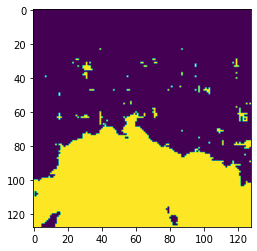

In [33]:
# Training and Testing with one single image
img_path = '/content/gdrive/My Drive/UBDS_college_work/SelfDrivingProject/Code/Semantic-Segmentation-Suite/CamVid/train/0006R0_f02460.png'
label_path = '/content/gdrive/My Drive/UBDS_college_work/SelfDrivingProject/Code/Semantic-Segmentation-Suite/CamVid/train_labels/0006R0_f02460_L.png'

img=cv2.imread(img_path,1)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
label=cv2.imread(label_path,1)
label = cv2.cvtColor(label,cv2.COLOR_BGR2RGB)

img_input       =cv2.resize(img,(128,128))
label_mask_input=cv2.resize(label,(128,128))
label_mask_input = define_channels(label_mask_input)

plot(img_input)
plot(label_mask_input)

img_input = np.expand_dims(img_input, axis=0)
label_mask_input = np.expand_dims(label_mask_input, axis=0)

print(img_input.shape)
print(label_mask_input.shape)

model_history = model.fit(x=img_input,y=label_mask_input,epochs=100)
pred=model.predict(img_input)
pred_0=pred[0]
mask = create_mask(pred)
mask=mask.numpy()
mask_img=np.zeros((mask.shape[0],mask.shape[1]))
for i in range(mask.shape[0]):
  for j in range(mask.shape[1]):
    mask_img[i,j]=mask[i,j,0]
plot(mask_img)

In [0]:
# Let's make our model super strong
img_path = '/content/gdrive/My Drive/UBDS_college_work/SelfDrivingProject/Code/Semantic-Segmentation-Suite/CamVid'

# function name : prepare_model_input
# Input         : image path, image size for resizing, number of channels/classes
# Output        : converts image to include 3 classes - Road, Pedestrian, Others
def prepare_model_input(img_path,n,channels):
  idx = 1
  for file in os.listdir(img_path + "/train" ):
    label_file = file.strip('.png') + '_L.png'
    if(label_file in os.listdir(img_path + "/train_labels")):
      img=cv2.imread(img_path+"/train/"+file,1)
      img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
      img=cv2.resize(img,(n,n))
      img = np.expand_dims(img, axis=0)
      label=cv2.imread(img_path + "/train_labels/" + label_file,1)
      label = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
      if(channels==3):
        label = define_channels(label)
      label=cv2.resize(label,(n,n))
      label = np.expand_dims(label, axis=0)
      if(idx==1):
        train_input = img
        train_label = label
        idx+=1
      else:
        train_input= np.concatenate((train_input,img))
        train_label = np.concatenate((train_label,label))

      
  return train_input,train_label


train_input, train_label = prepare_model_input(img_path,128,3)

In [41]:

#train_input, train_label = prepare_model_input(img_path,128,3)

checkpoint_path = "/content/gdrive/My Drive/UBDS_college_work/SelfDrivingProject/Code/Semantic-Segmentation-Suite/training_weights/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1, frequency = 5)
# Create a basic model instance
model = create_model(base_model,OUTPUT_CHANNELS)
# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path)

model_history = model.fit(x=train_input,y=train_label,epochs=1,callbacks=[cp_callback])

14/14 [==============================] - ETA: 0s - loss: 0.3876 - accuracy: 0.8425
Epoch 00001: saving model to /content/gdrive/My Drive/UBDS_college_work/SelfDrivingProject/Code/Semantic-Segmentation-Suite/training_weights/cp.ckpt
14/14 [==============================] - 31s 2s/step - loss: 0.3876 - accuracy: 0.8425


In [42]:
# Create a new model instance
model = create_model(base_model,OUTPUT_CHANNELS)

# Load the previously saved weights
latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)
model.load_weights(latest)

/content/gdrive/My Drive/UBDS_college_work/SelfDrivingProject/Code/Semantic-Segmentation-Suite/training_weights/cp.ckpt


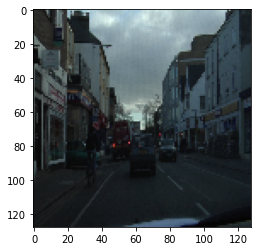

(1, 128, 128, 3)
Nikita's method to create classes


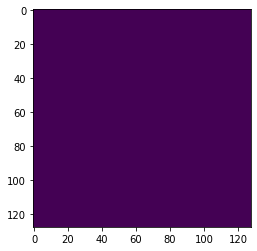

TF function to create classes


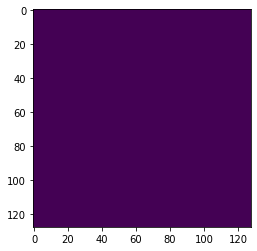

In [43]:
# testing the model
img_path = '/content/gdrive/My Drive/UBDS_college_work/SelfDrivingProject/Code/Semantic-Segmentation-Suite/CamVid/train/0001TP_007950.png'
test_img=cv2.imread(img_path,1)
test_img =cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
test_img =cv2.resize(test_img,(128,128))
plot(test_img)
test_img = np.expand_dims(test_img, axis=0)

pred=model.predict(test_img)
print(pred.shape)

pred_0=pred[0]
pred_max=np.zeros((pred_0.shape[0],pred_0.shape[1]))
for i in range(pred_0.shape[0]):
  for j in range(pred_0.shape[1]):
    if pred_0[i,j,0]>pred_0[i,j,1] and pred_0[i,j,0]>pred_0[i,j,2]:
      pred_max[i,j]=0
    elif pred_0[i,j,1]>pred_0[i,j,0] and pred_0[i,j,1]>pred_0[i,j,2]:
      pred_max[i,j]=1
    else:
      pred_max[i,j]=2

print("Nikita's method to create classes")
plot(pred_max)


mask = create_mask(pred)
# plot(mask)
mask=mask.numpy()
mask_img=np.zeros((mask.shape[0],mask.shape[1]))
for i in range(mask.shape[0]):
  for j in range(mask.shape[1]):
    mask_img[i,j]=mask[i,j,0]

print("TF function to create classes")
plot(mask_img)
